In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn
from nilearn import image
from pathlib import Path 
import itertools

import os, sys, glob, re
from os.path import join, exists, split
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')
import time

import glmsingle
from glmsingle.glmsingle import GLM_single

In [2]:
__author__ = "Heejung Jung"
__copyright__ = "Spatial Topology Project"
__credits__ = ["Heejung"] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung@colorado.edu"
__status__ = "Development" 

In [3]:
cluster = 1
if cluster:
    glmsingle_dir = '/dartfs-hpc/rc/lab/C/CANlab/modules/GLMsingle'
#     fmriprep_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop/derivatives/fmriprep'
    fmriprep_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep/results/fmriprep'
    current_dir = os.getcwd()
    main_dir = Path(current_dir).parents[1] # discovery: /dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social
else:
    glmsingle_dir = '/dartfs-hpc/rc/lab/C/CANlab/modules/GLMsingle'
    fmriprep_dir = '/Volumes/spacetop/derivatives/fmriprep'
    main_dir = '/Volumes/spacetop_projects_social'

In [4]:
main_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social'

In [5]:
datadir = join(main_dir,'analysis','fmri','glmsingle','data')
outputdir = join(main_dir,'analysis','fmri','glmsingle','output')
Path(datadir).mkdir(parents=True, exist_ok=True)
Path(outputdir).mkdir(parents=True, exist_ok=True)
print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example1 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/analysis/fmri/glmsingle/data

directory to save example1 outputs:
	/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/analysis/fmri/glmsingle/output



In [6]:
onset_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM'
# structure onset_dir/{sub}/{ses}/sub-0061_ses-04_task-social_run-03-pain_events_ttl.tsv

In [19]:
tl_key = 'plateau'
sub_ind = [73]
ttl_key = 'plateau'
task = 'pain'
ses_list = [1,3,4]
ttl_dir = {
    'early':'d06_singletrial_SPM_01-pain-early',
    'late':'d06_singletrial_SPM_02-pain-late',
    'post':'d06_singletrial_SPM_03-pain-post',
    'plateau':'d06_singletrial_SPM_04-pain-plateau'
}
# ses = sys.argv[2]
design = []
extra = []
data = []
ses_indicator = []

In [20]:
beh_list = []
sub_ses = list(itertools.product(sub_ind, ses_list))

for i, (sub_ind, ses_ind) in enumerate(sub_ses):
    sub = f'sub-{sub_ind:04d}'
    ses = f'ses-{ses_ind:02d}'
#    /sub-0061/ses-04/sub-0061_ses-04_task-social_run-06-pain_events_ttl.tsv
    beh_names = sorted(glob.glob(join(onset_dir,  sub, ses,  f"{sub}_{ses}_task-social_run-*-pain_events_ttl.tsv")))
    #beh_list = glob.glob(join(main_dir, 'data', 'dartmouth', 'd02_preprocessed', sub, ses,  f"{sub}_{ses}_task-social_run-*-pain_beh.csv"))
    Path(join(datadir, sub)).mkdir(parents=True, exist_ok=True)
    Path(join(outputdir, sub)).mkdir(parents=True, exist_ok=True)
    beh_list.append(beh_names)


In [21]:
sub_ses

[(73, 1), (73, 3), (73, 4)]

In [23]:
flat_list = [item for sublist in beh_list for item in sublist]

In [93]:

    ev2 = beh['event02_expect_displayonset'] 
    # ev3 = beh['event03_stimulus_displayonset'] - beh['param_trigger_onset'][0]
    ev4 = beh['event04_actual_displayonset'] 
    design_df = pd.DataFrame(columns = ['order', 'onset', 'condition_type', 'cue', 'stim', 'task'])
    onset = beh['TTL2']
    df_dict = {'order':list(range(len(run_df))), 
    'onset':np.array(beh['TTL2']), 
    'condition_type':run_df['cond_name'].values, 
    'task':task}
    design_df = pd.DataFrame.from_dict(df_dict)
    # design_df['condition_name'] = design_df['condition_type'].map(cond_name_inv)
    # NOTE: what was I doing here? 09-12-2022
    design_df['tr'] = round(design_df['onset'].astype(np.float)/0.46).astype(int)


In [95]:
    dim_x = 872;    dim_y = 6
    order_tr = list(design_df[['tr','condition_type']].apply(tuple, axis = 1))
    design_mat = np.zeros((dim_x, dim_y), dtype = int)
    for el_x, el_y in order_tr:
        design_mat[int(el_x), int(el_y)] = 1
    design.append(design_mat)

In [96]:
    xtra_y = 1;
#     rating_onset = pd.concat([ev2,ev4],ignore_index = True)
    # motion_fname = join(main_dir, 'data', 'dartmouth', 'd05_motion', sub, ses, f"{sub}_{ses}_task-social_run-{run}_confounds-subset.txt")
    motion_fname = join(main_dir, 'data', 'd04_motion', 'csf_24dof_dummy_spike', sub, ses, f"{sub}_{ses}_task-social_{run}_confounds-subset.txt")
    print(motion_fname)
    motion_df = pd.read_csv(motion_fname, sep = '\t', header = None)
#     rating_tr = round(rating_onset/0.46).astype(int)
    # load motion covariates and concat
    rating_df = pd.DataFrame(np.zeros(dim_x), dtype = int)
#     for x in rating_tr:
#         rating_df.iloc[x-1, 0] = 1
    extra_df = pd.concat([rating_df, motion_df], axis = 1)
    extra.append(np.array(extra_df))

/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d04_motion/csf_24dof_dummy_spike/sub-0061/ses-04/sub-0061_ses-04_task-social_run-03_confounds-subset.txt


In [97]:
extra

[array([[ 0.00000000e+00,  4.21460218e+03, -6.02041000e-02, ...,
          5.61615348e-05,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  4.10115529e+03, -6.36510000e-02, ...,
          7.57025285e-05,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  4.04568609e+03, -6.81348000e-02, ...,
          6.78893602e-05,  1.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  3.88086202e+03, -2.03321000e-01, ...,
          5.58836983e-05,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  3.89119161e+03, -2.08246000e-01, ...,
          5.30533054e-05,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  3.88555751e+03, -2.11436000e-01, ...,
          5.53772617e-05,  0.00000000e+00,  0.00000000e+00]])]

In [99]:

    nii_name = join(fmriprep_dir, sub, ses, 'func', f"{sub}_{ses}_task-social_acq-mb8_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
    nilearn_data = image.load_img(nii_name) 
    data.append(nilearn_data.get_fdata())
    ses_indicator = []
#     ses_indicator.append(ses_num)

In [24]:
flat_list

['/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-01/sub-0073_ses-01_task-social_run-03-pain_events_ttl.tsv',
 '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-01/sub-0073_ses-01_task-social_run-06-pain_events_ttl.tsv',
 '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-03/sub-0073_ses-03_task-social_run-01-pain_events_ttl.tsv',
 '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-03/sub-0073_ses-03_task-social_run-06-pain_events_ttl.tsv',
 '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-04/sub-0073_ses-04_task-social_run-02-pain_events_ttl.tsv',
 '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-04/sub-0073_ses-04_task-soci

# run for loop

In [60]:
beh_fname

'/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/data/d03_onset/onset02_SPM/sub-0073/ses-04/sub-0073_ses-04_task-social_run-05-pain_events_ttl.tsv'

In [59]:
stimdur = 5
tr = 0.46
# print some relevant metadata
print(f'* There are {len(data)} runs in total')
print(f'* N = {data[0].shape[3]} TRs per run')
print(f'* The dimensions of the data for each run are: {data[0].shape}')
print(f'* The stimulus duration is {stimdur} seconds')
print(f'* XYZ dimensionality is: {data[0].shape[:3]} (one slice only in this example)')
print(f'* Numeric precision of data is: {type(data[0][0,0,0,0])}')

* There are 6 runs in total
* N = 872 TRs per run
* The dimensions of the data for each run are: (73, 86, 73, 872)
* The stimulus duration is 5 seconds
* XYZ dimensionality is: (73, 86, 73) (one slice only in this example)
* Numeric precision of data is: <class 'numpy.float64'>


In [27]:
ses_ind = []
design = []
extra = []
data = []
ses_indicator = []
for beh_fname in flat_list:
    # extract info from globbed files
    beh_basename = os.path.basename(beh_fname)
    ses_num = int(re.findall('\d+', [match for match in beh_basename.split('_') if "ses" in match][0])[0])
    run_num = int(re.findall('\d+', [match for match in beh_basename.split('_') if "run" in match][0])[0])
    task_name = re.match("(run)-(\d+)-(\w+)", [match for match in beh_basename.split('_') if "run" in match][0])[3]
    ses = 'ses-{:02d}'.format(ses_num)
    run = 'run-{:02d}'.format(run_num)

    # load csv and clean 
    beh = pd.read_csv(beh_fname, sep = '\t')
    # TODO, check if plataeu exists
    # ttl = pd.read_csv(join(main_dir, 'data', 'dartmouth', ttl_dir[ttl_key], sub, f"{sub}_singletrial_{ttl_key}.csv"))
    metafiles = glob.glob(join(main_dir, 'data', 'd03_onset', 'onset03_SPMsingletrial', sub, f"{sub}_singletrial*.csv"))
    if len(metafiles) > 1:
        meta = pd.read_csv(join(main_dir, 'data', 'd03_onset', 'onset03_SPMsingletrial', sub, f"{sub}_singletrial_plateau.csv"))
    else:
        meta = pd.read_csv(join(main_dir, 'data', 'd03_onset', 'onset03_SPMsingletrial', sub, f"{sub}_singletrial.csv"))
    rating = pd.read_csv(join(main_dir, 'data', 'd03_onset', 'onset03_SPMsingletrial', sub, f"{sub}_{ses}_{run}_covariate-circularrating.csv"))
    run_df = meta[((meta['ses'] == ses_num)& (meta['run'] == run_num) & (meta['ev'] == 'stim'))]
    run_df.insert(2, 'cond_name', np.nan)
    # %% building <design> from glmsingle _______________________________________________________________
    run_df.loc[((run_df['cue_type'] == 'low_cue') & (run_df['stim_type']  =='low_stim')), 'cond_name'] = int(0)
    run_df.loc[((run_df['cue_type'] == 'low_cue') & (run_df['stim_type']  =='med_stim')), 'cond_name'] = int(1)
    run_df.loc[((run_df['cue_type'] == 'low_cue') & (run_df['stim_type']  =='high_stim')),'cond_name'] = int(2)
    run_df.loc[((run_df['cue_type'] == 'high_cue') & (run_df['stim_type'] =='low_stim')), 'cond_name'] = int(3)
    run_df.loc[((run_df['cue_type'] == 'high_cue') & (run_df['stim_type'] =='med_stim')), 'cond_name'] = int(4)
    run_df.loc[((run_df['cue_type'] == 'high_cue') & (run_df['stim_type'] =='high_stim')),'cond_name'] = int(5)

    design_df = pd.DataFrame(columns = ['order', 'onset', 'condition_type', 'cue', 'stim', 'task'])
    onset = run_df['onset']
    df_dict = {'order':list(range(len(run_df))), 
    'onset':np.array(run_df['onset']), 
    'condition_type':run_df['cond_name'], 
    'task':task_name}
    design_df = pd.DataFrame.from_dict(df_dict)
    # design_df['condition_name'] = design_df['condition_type'].map(cond_name_inv)
    design_df['tr'] = round(design_df['onset'].apply(lambda x: float(x))/0.46).astype(int) # round(design_df['onset']/0.46).astype(int)
    design_df['condition_type'] = design_df['condition_type'].astype(int)
    dim_x = 872;    dim_y = 6
    order_tr = list(design_df[['tr','condition_type']].apply(tuple, axis = 1))
    design_mat = np.zeros((dim_x, dim_y), dtype = int)
    for el_x, el_y in order_tr:
        design_mat[el_x-1, el_y] = 1
    design.append(design_mat)
    
    xtra_y = 1;
    rating_onset = rating['rating']#pd.concat([ev2,ev4],ignore_index = True)
    motion_fname = join(main_dir, 'data', 'd03_onset', 'onset03_SPMsingletrial', sub, f"{sub}_{ses}_task-social_{run}_confounds-subset.txt")
    motion_df = pd.read_csv(motion_fname, sep = '\t', header = None)
    rating_tr = round(rating_onset/0.46).astype(int)
    # load motion covariates and concat
    rating_df = pd.DataFrame(np.zeros(dim_x), dtype = int)
    for x in rating_tr:
        rating_df.iloc[x-1, 0] = 1
    extra_df = pd.concat([rating_df, motion_df], axis = 1)
    extra.append(np.array(extra_df))

    nii_name = join(fmriprep_dir, sub, ses, 'func', f"{sub}_{ses}_task-social_acq-mb8_run-{run_num}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
    print(nii_name)
    nilearn_data = image.load_img(nii_name) 
    data.append(nilearn_data.get_fdata())

    ses_ind.append(ses_num)

/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep/results/fmriprep/sub-0073/ses-01/func/sub-0073_ses-01_task-social_acq-mb8_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep/results/fmriprep/sub-0073/ses-01/func/sub-0073_ses-01_task-social_acq-mb8_run-6_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep/results/fmriprep/sub-0073/ses-03/func/sub-0073_ses-03_task-social_acq-mb8_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep/results/fmriprep/sub-0073/ses-03/func/sub-0073_ses-03_task-social_acq-mb8_run-6_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep/results/fmriprep/sub-0073/ses-04/func/sub-0073_ses-04_task-social_acq-mb8_run-2_space-MNI152NLin

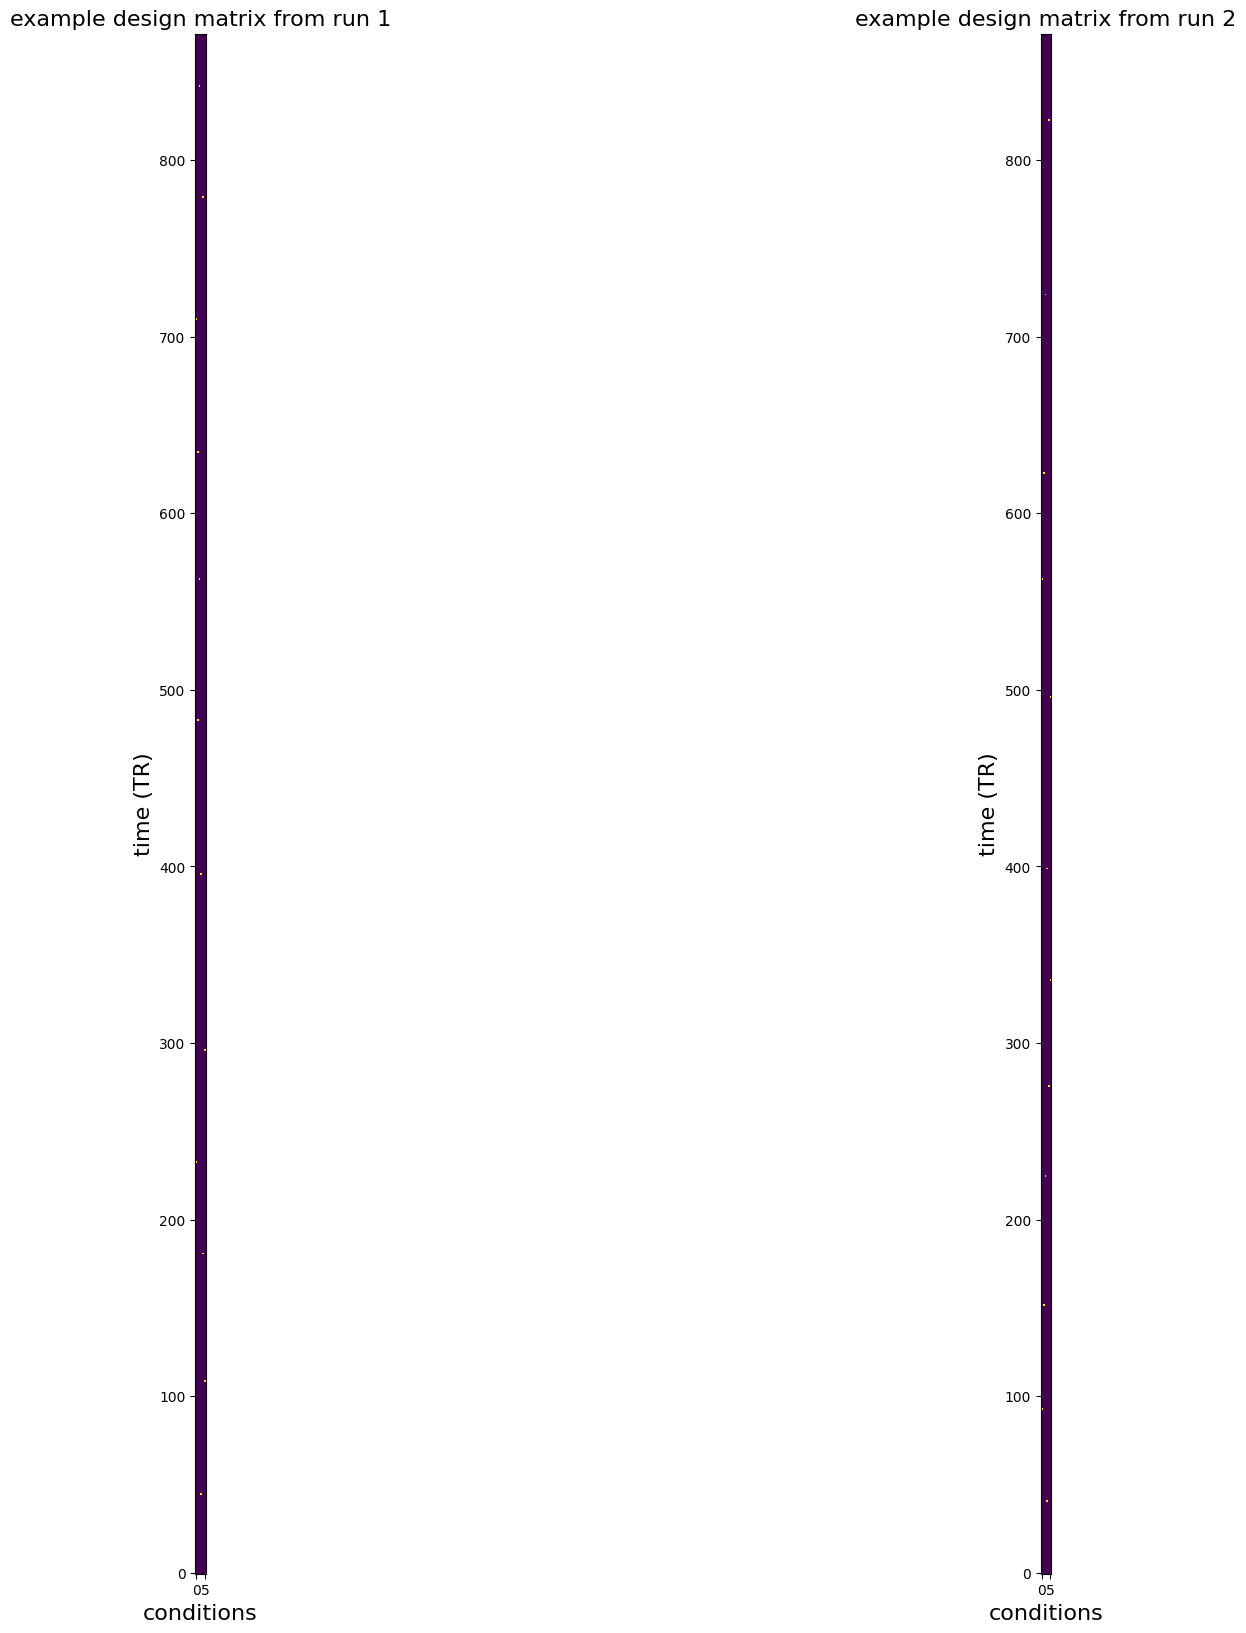

In [53]:
# %% visualize design
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(design[0],origin = 'lower', interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);
plt.subplot(122)
plt.imshow(design[1],origin = 'lower', interpolation='none')
plt.title('example design matrix from run 2',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

# session indicator

In [44]:
a = np.array(ses_ind)
x,ses_ind_zerobased = np.unique(a,return_inverse = True)

Text(0.5, 1.0, 'example slice from run 2')

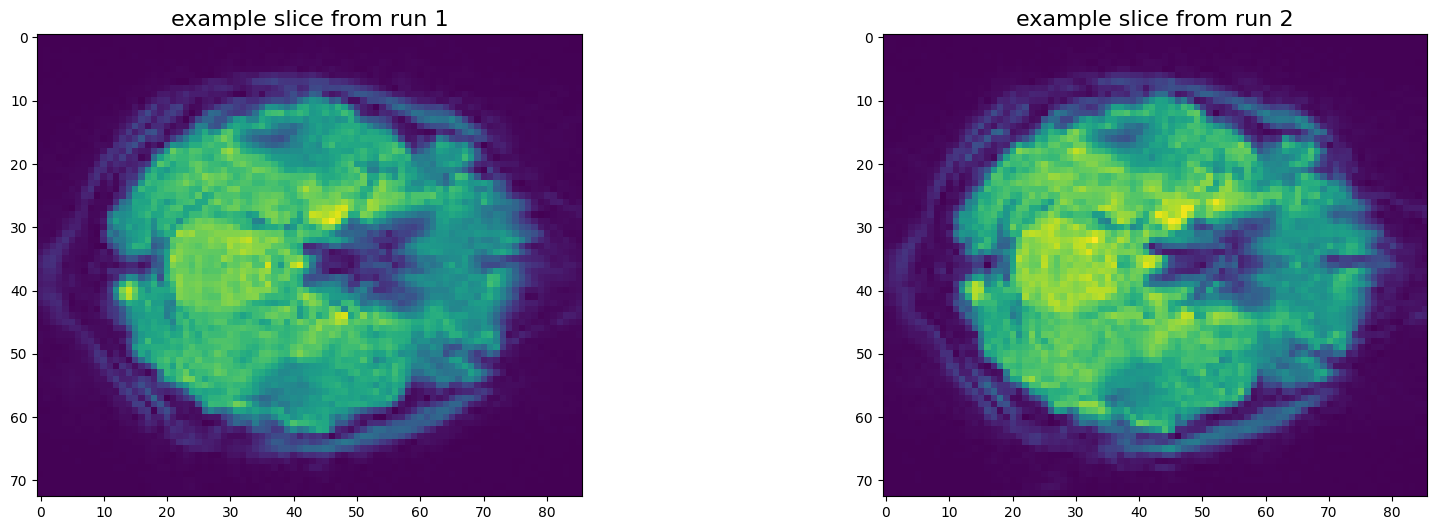

In [36]:
# %% visualize data
# plot example slice from run 1
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,23,31])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[1][:,:,23,31])
plt.title('example slice from run 2',fontsize=16)

In [37]:
sum(data[0][:,:,23,31] - data[1][:,:,23,31])

array([  1744.20393011,   2495.52944428,   1499.70805138,   -572.02645722,
        -1397.42771125,    -70.57443306,   -296.20808038,   -806.74632335,
         -580.37932158,   -244.33867133,   1164.78014043,   2711.21760356,
          487.94204417,   1719.91448259,    524.03105214,    212.20219529,
        -2392.7402218 ,   1105.47087827,    619.19057155,   2216.29116008,
          673.30149972,   2087.46772552,   2405.51588079,   2225.11657885,
          803.73098034,  -1285.45058426,  -4155.53210083,  -6821.48465979,
        -4191.89030889,  -1370.07141748,    564.68748662,  -5195.71524411,
        -8262.84939161,  -6876.75431278,  -7089.16301626,  -5136.24085715,
          -95.89530411,   1027.51949972,    393.55910626,   2761.06990302,
         3192.06901765,   1896.77525049,  -2626.9779402 ,  -3265.98873413,
        -5623.95928195,    -29.24741268,   2585.74572262,  -3348.10990992,
        -1462.88317814,    233.84755686,  -2031.96236026,  -4618.49942401,
        -6351.35935938,  

In [40]:
extra[0].shape

(872, 10)

In [41]:
data[0].shape

(73, 86, 73, 872)

In [48]:
outputdir

'/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_social/analysis/fmri/glmsingle/output'

# glmsingle begin

In [80]:
outputdir_glmsingle = join(outputdir,sub, task)
Path(join(outputdir_glmsingle)).mkdir(parents=True, exist_ok=True) # (main_dir,'analysis','fmri','glmsingle','output', 'sub-0001', 'task-social')
opt = dict()

opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]
# opt['sessionindicator'] = [1, 1]
opt['extra_regressors'] = False
opt['sessionindicator'] = list(ses_ind_zerobased +1)
opt['chunklen'] = 50000
glmsingle_obj = GLM_single(opt)

pprint(glmsingle_obj.params) 

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1666725260.93896,
 'sessionindicator': [1, 1, 2, 2, 3, 3],
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [74]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


[('meta', 352998),
 ('extra_df', 69920),
 ('motion_df', 62944),
 ('design_mat', 41976),
 ('run_df', 7245),
 ('rating_df', 7136),
 ('beh', 4311),
 ('design_df', 1931),
 ('opt', 1192),
 ('GLM_single', 1064),
 ('onset', 911),
 ('Path', 896),
 ('rating', 544),
 ('rating_onset', 352),
 ('rating_tr', 352),
 ('nii_name', 255),
 ('df_dict', 248),
 ('results_glmsingle', 248),
 ('ttl_dir', 248),
 ('order_tr', 224),
 ('motion_fname', 221),
 ('beh_fname', 216),
 ('outputdir_glmsingle', 163),
 ('a', 152),
 ('ses_ind_zerobased', 152),
 ('y', 152),
 ('outputdir', 149),
 ('datadir', 147),
 ('onset_dir', 145),
 ('exists', 144),
 ('forceAspect', 144),
 ('join', 144),
 ('split', 144),
 ('current_dir', 143),
 ('fmriprep_dir', 141),
 ('data', 136),
 ('design', 136),
 ('extra', 136),
 ('flat_list', 136),
 ('ses_ind', 136),
 ('x', 128),
 ('sub_ses', 120),
 ('main_dir', 118),
 ('beh_names', 112),
 ('metafiles', 112),
 ('beh_list', 104),
 ('beh_basename', 103),
 ('ses_list', 96),
 ('glmsingle_dir', 94),
 ('ima

In [73]:
# this example saves output files to the folder  "example1outputs/GLMsingle"
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

if not exists(join(outputdir_glmsingle,'TYPEA_ONOFF.npy')):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

running GLMsingle...
*** FITTING TYPE-A MODEL (ONOFF) ***



MemoryError: Unable to allocate 1.49 GiB for an array with shape (872, 458294) and data type float32

In [78]:
data[0].shape

(458294, 872)

In [79]:
# this example saves output files to the folder  "example1outputs/GLMsingle"
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

MemoryError: Unable to allocate 1.49 GiB for an array with shape (399632368,) and data type float32

In [63]:
(73, 86, 73, 872)[:3]

(73, 86, 73)

In [78]:

xyz = (73, 86, 73)
new_reshape = (73,86,73,24)
xyzt = (73, 86, 73, 872)

In [49]:
results_glmsingle = dict()
results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

In [71]:
plot_data = results_glmsingle['typed']['betasmd'].reshape((73,86,73,24))

In [72]:
plot_data.shape

(73, 86, 73, 24)

Text(0.5, 1.0, 'example slice from run 1')

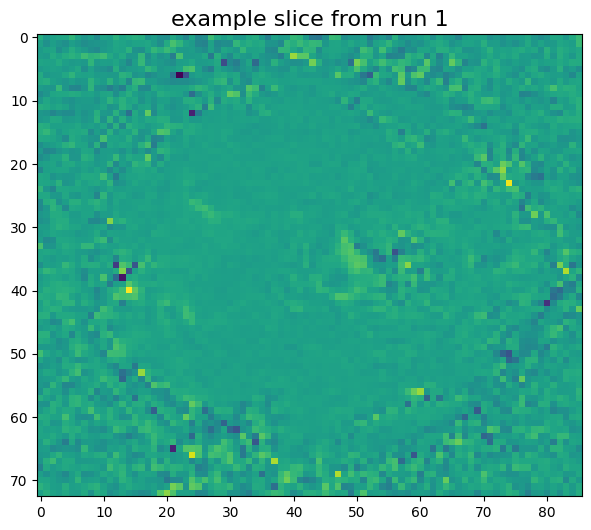

In [74]:
# %% visualize data
# plot example slice from run 1
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(plot_data[:,:,23,12])
plt.title('example slice from run 1',fontsize=16)
# plt.subplot(122)
# plt.imshow(data[1][:,:,23,31])
# plt.title('example slice from run 2',fontsize=16)

In [123]:
np.nanmean(np.squeeze(results_glmsingle['typed']['betasmd']),1).reshape(xyz).shape

(73, 86, 73)

In [118]:
np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]))

0.22061005

In [128]:
results_glmsingle['typed']['betasmd'].shape

(458294, 24)

In [130]:
np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),1).shape

(458294,)

0
0 finished
1
1 finished
2
2 finished
3
3 finished


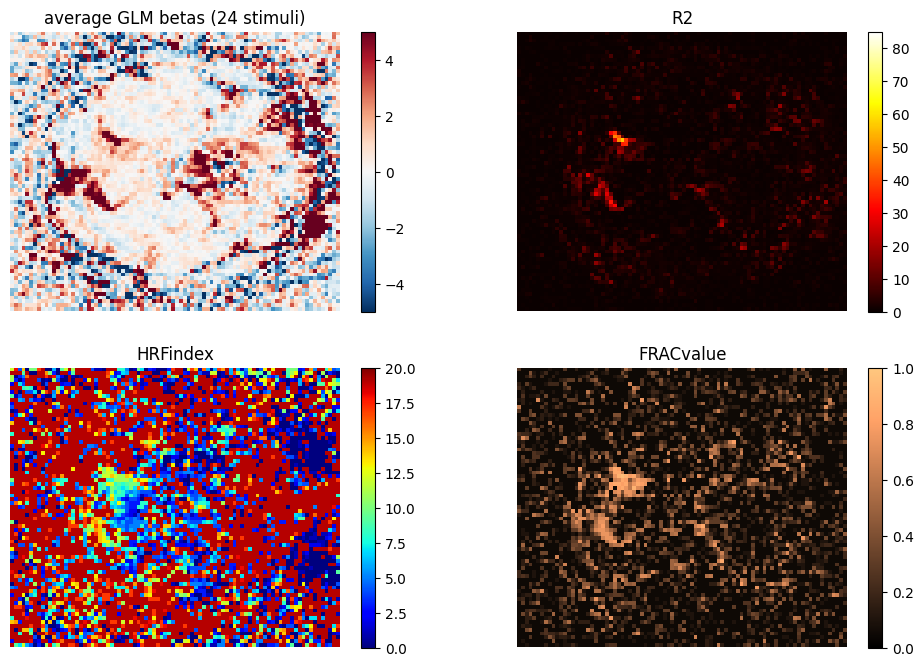

In [131]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in [0,1,2,3]: #range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        print(i)
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        if results_glmsingle['typed'][plot_fields[i]].ndim == 1:
            plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),1).reshape(xyz)
        else:
            plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),1).reshape(xyz)
        titlestr = 'average GLM betas (24 stimuli)'
        plt.imshow(plot_data[:,:,23],cmap=colormaps[i],clim=clims[i])
        plt.colorbar()
        plt.title(titlestr)
        plt.axis(False)
        print(i, 'finished')
    else:
        print(i)
        # plot all other voxel-wise metrics as outputted from GLMsingle
        if results_glmsingle['typed'][plot_fields[i]].ndim == 1:
            plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz))
            titlestr = plot_fields[i]
            plt.imshow(plot_data[:,:,23],cmap=colormaps[i],clim=clims[i])
            plt.colorbar()
            plt.title(titlestr)
            plt.axis(False)
        else:
            plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(new_reshape))
            titlestr = plot_fields[i]
            plt.imshow(plot_data[:,:23,12],cmap=colormaps[i],clim=clims[i])
            plt.colorbar()
            plt.title(titlestr)
            plt.axis(False)
        print(i, 'finished')


In [127]:
# variables that will contain bold time-series and design matrices from each run
data = []
design = []

# iterate through each run of data
for r in range(len(X['data'][0])):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

# get visual ROI mask identifying occipital cortex
roi = X['ROI']

NameError: name 'X' is not defined

In [179]:
 plot_data = np.nanmean(np.squeeze(results_glmsingle['typeb']['betasmd']),1
                       )

In [180]:
plot_data.shape

(458294,)

In [181]:
plot_data = np.squeeze(results_glmsingle['typeb']['betasmd'].reshape((73, 86, 73)))

ValueError: cannot reshape array of size 5499528 into shape (73,86,73)

In [133]:
models = dict()
xyz = (73, 86, 73)
models['assumehrf'] = results_glmsingle['typeb']['betasmd'].reshape(xyz + (24,))
models['fithrf'] = results_glmsingle['typeb']['betasmd']
# models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
# models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

In [134]:
models['assumehrf'].shape

(73, 86, 73, 24)

In [135]:
np.nanmean(np.squeeze(models['assumehrf']), axis = 3).shape

(73, 86, 73)

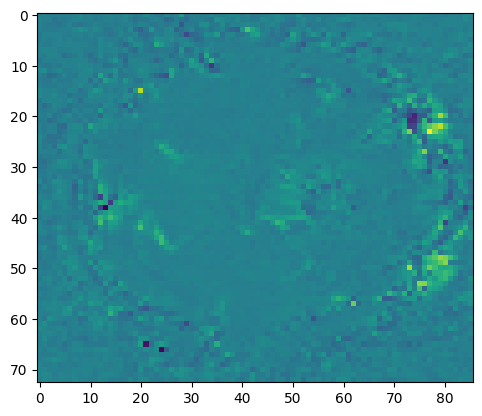

In [136]:
plt.imshow(np.nanmean(np.squeeze(models['assumehrf']), axis = 3)[:,:,23])

TypeError: Invalid shape (3,) for image data

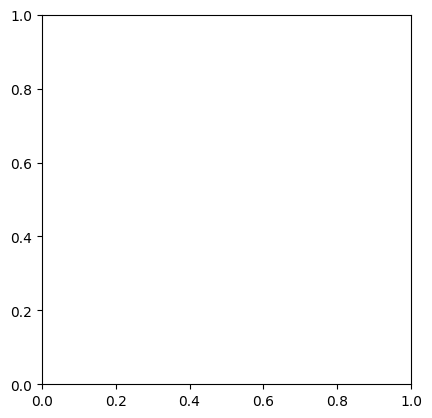

In [137]:
# plot_data = np.nanmean(np.squeeze(results_glmsingle['typeb']['betasmd']),1)
# plot_data = np.nanmean(np.squeeze(results_glmsingle['typeb']['betasmd'].reshape(73, 86, 73)))
plt.imshow(np.nanmean(np.squeeze(models['assumehrf']), axis = 3).shape, 'RdBu_r', clim = [-5,5])
